<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/MLP/MLP_Gilt10y.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (145/145), done.
remote: Total 150 (delta 73), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (150/150), 121.14 KiB | 6.73 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Fri Jul 23 11:43:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Gilt10y'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'MLP'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8 MB 5.2 MB/s 
     |████████████████████████████████| 97 kB 4.9 MB/s 
     |████████████████████████████████| 138 kB 46.6 MB/s 
     |████████████████████████████████| 177 kB 50.2 MB/s 
     |████████████████████████████████| 133 kB 48.2 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 62 kB 836 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop', 'sgd']
        },
        'activation': {
            'values': ['relu', 'selu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(Dense(256, activation=config.activation, input_shape=(window_len, 1)))
    # layer 2
    model.add(Dense(128, activation=config.activation))
    # layer 3
    model.add(Dense(64, activation=config.activation))
    # layer 4
    model.add(Dense(32, activation=config.activation))
    # layer 5
    model.add(Flatten())
    # layer 6
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: 1q7gumdj
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_MLP/sweeps/1q7gumdj


In [15]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: n5y4igw4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/100
16/16 [==============================] - 19s 65ms/step - loss: 0.0861 - mean_squared_error: 0.0861 - mean_absolute_error: 0.2207 - val_loss: 0.0478 - val_mean_squared_error: 0.0478 - val_mean_absolute_error: 0.1840
Epoch 2/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0115 - mean_squared_error: 0.0115 - mean_absolute_error: 0.0908 - val_loss: 0.0514 - val_mean_squared_error: 0.0514 - val_mean_absolute_error: 0.1938
Epoch 3/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - mean_absolute_error: 0.0937 - val_loss: 0.0435 - val_mean_squared_error: 0.0435 - val_mean_absolute_error: 0.1750
Epoch 4/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0636 - val_loss: 0.0597 - val_mean_squared_error: 0.0597 - val_mean_absolute_error: 0.2088
Epoch 5/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0135 - mean_squared

epoch,99
loss,0.0021
mean_squared_error,0.0021
mean_absolute_error,0.03503
val_loss,0.00729
val_mean_squared_error,0.00729
val_mean_absolute_error,0.0657
_runtime,48
_timestamp,1627040681
_step,99
best_val_loss,0.00715


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▂▁▁▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▁▁▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▃▃▃▃▂▃▃▂▃▁▃▁▂▂▂▂▂▂▁▁▂▂▁▁▂▂▁▁▁▁▂▁▁▂▁▂
val_loss,█▇▅▄▃▄▃▂▂▂▂▂▂▂▂▂▂▁▃▁▁▁▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▅▄▃▄▃▂▂▂▂▂▂▂▂▂▂▁▃▁▁▁▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▅▄▄▄▃▃▂▂▃▃▂▃▂▂▂▄▂▂▂▂▂▂▂▁▂▁▁▂▂▁▁▂▂▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: jj0mq755 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 3s 50ms/step - loss: 0.1518 - mean_squared_error: 0.1518 - mean_absolute_error: 0.2719 - val_loss: 0.0326 - val_mean_squared_error: 0.0326 - val_mean_absolute_error: 0.1530
Epoch 2/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0145 - mean_squared_error: 0.0145 - mean_absolute_error: 0.1059 - val_loss: 0.0156 - val_mean_squared_error: 0.0156 - val_mean_absolute_error: 0.0983
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0532 - val_loss: 0.0179 - val_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.1057
Epoch 4/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0364 - val_loss: 0.0128 - val_mean_squared_error: 0.0128 - val_mean_absolute_error: 0.0890
Epoch 5/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0012 - mean_squared_

epoch,74
loss,0.00065
mean_squared_error,0.00065
mean_absolute_error,0.0197
val_loss,0.0061
val_mean_squared_error,0.0061
val_mean_absolute_error,0.06092
_runtime,24
_timestamp,1627040728
_step,74
best_val_loss,0.0059


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▃▁▂▁▁▂▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁
val_loss,█▄▃▃▃▆▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▃▃▆▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▃▆▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 0rz4ijw7 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 2s 28ms/step - loss: 53.7193 - mean_squared_error: 53.7193 - mean_absolute_error: 3.6326 - val_loss: 0.3686 - val_mean_squared_error: 0.3686 - val_mean_absolute_error: 0.5031
Epoch 2/100
32/32 [==============================] - 0s 10ms/step - loss: 0.3113 - mean_squared_error: 0.3113 - mean_absolute_error: 0.3618 - val_loss: 0.3646 - val_mean_squared_error: 0.3646 - val_mean_absolute_error: 0.5012
Epoch 3/100
32/32 [==============================] - 0s 9ms/step - loss: 1.0416 - mean_squared_error: 1.0416 - mean_absolute_error: 0.7552 - val_loss: 0.0599 - val_mean_squared_error: 0.0599 - val_mean_absolute_error: 0.1953
Epoch 4/100
32/32 [==============================] - 0s 11ms/step - loss: 0.8299 - mean_squared_error: 0.8299 - mean_absolute_error: 0.3213 - val_loss: 0.0898 - val_mean_squared_error: 0.0898 - val_mean_absolute_error: 0.2431
Epoch 5/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0305 - mean_squared

epoch,21
loss,9.13306
mean_squared_error,9.13306
mean_absolute_error,1.05882
val_loss,0.05342
val_mean_squared_error,0.05342
val_mean_absolute_error,0.17706
_runtime,13
_timestamp,1627040748
_step,21
best_val_loss,0.02189


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
loss,█▁▁▂▁▁▁▁▁▁▂▁▁▁▂▁▂▁▁▁▁▄
mean_squared_error,█▁▁▂▁▁▁▁▁▁▂▁▁▁▂▁▂▁▁▁▁▄
mean_absolute_error,█▂▃▅▁▁▄▁▃▁▃▁▃▁▄▁▃▂▁▂▁▆
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▃▁
val_mean_squared_error,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▃▁
val_mean_absolute_error,▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▄▁
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇▇▇██
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: wvf7vme5 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 2s 46ms/step - loss: 0.1951 - mean_squared_error: 0.1951 - mean_absolute_error: 0.3503 - val_loss: 0.0559 - val_mean_squared_error: 0.0559 - val_mean_absolute_error: 0.1978
Epoch 2/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0774 - val_loss: 0.0241 - val_mean_squared_error: 0.0241 - val_mean_absolute_error: 0.1233
Epoch 3/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0374 - val_loss: 0.0143 - val_mean_squared_error: 0.0143 - val_mean_absolute_error: 0.0931
Epoch 4/50
16/16 [==============================] - 0s 10ms/step - loss: 9.5971e-04 - mean_squared_error: 9.5971e-04 - mean_absolute_error: 0.0249 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0860
Epoch 5/50
16/16 [==============================] - 0s 11ms/step - loss: 8.1455e-04 - mean_s

epoch,41
loss,0.00045
mean_squared_error,0.00045
mean_absolute_error,0.01636
val_loss,0.00608
val_mean_squared_error,0.00608
val_mean_absolute_error,0.05994
_runtime,14
_timestamp,1627040770
_step,41
best_val_loss,0.00597


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: ugy0olwp with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 2s 29ms/step - loss: 0.1050 - mean_squared_error: 0.1050 - mean_absolute_error: 0.2543 - val_loss: 0.0351 - val_mean_squared_error: 0.0351 - val_mean_absolute_error: 0.1460
Epoch 2/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0555 - val_loss: 0.0336 - val_mean_squared_error: 0.0336 - val_mean_absolute_error: 0.1490
Epoch 3/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0425 - val_loss: 0.0308 - val_mean_squared_error: 0.0308 - val_mean_absolute_error: 0.1404
Epoch 4/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0371 - val_loss: 0.0263 - val_mean_squared_error: 0.0263 - val_mean_absolute_error: 0.1292
Epoch 5/100
32/32 [==============================] - 0s 12ms/step - loss: 0.0019 - mean_squared_

epoch,99
loss,0.00044
mean_squared_error,0.00044
mean_absolute_error,0.01624
val_loss,0.0055
val_mean_squared_error,0.0055
val_mean_absolute_error,0.05646
_runtime,43
_timestamp,1627040820
_step,99
best_val_loss,0.00548


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: evj7x87d with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/100
32/32 [==============================] - 2s 28ms/step - loss: 0.2154 - mean_squared_error: 0.2154 - mean_absolute_error: 0.4021 - val_loss: 0.0627 - val_mean_squared_error: 0.0627 - val_mean_absolute_error: 0.2014
Epoch 2/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0474 - mean_squared_error: 0.0474 - mean_absolute_error: 0.1671 - val_loss: 0.0464 - val_mean_squared_error: 0.0464 - val_mean_absolute_error: 0.1812
Epoch 3/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0338 - mean_squared_error: 0.0338 - mean_absolute_error: 0.1535 - val_loss: 0.0444 - val_mean_squared_error: 0.0444 - val_mean_absolute_error: 0.1772
Epoch 4/100
32/32 [==============================] - 0s 9ms/step - loss: 0.0284 - mean_squared_error: 0.0284 - mean_absolute_error: 0.1396 - val_loss: 0.0427 - val_mean_squared_error: 0.0427 - val_mean_absolute_error: 0.1738
Epoch 5/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0265 - mean_squared_e

epoch,99
loss,0.00222
mean_squared_error,0.00222
mean_absolute_error,0.03663
val_loss,0.02922
val_mean_squared_error,0.02922
val_mean_absolute_error,0.13626
_runtime,40
_timestamp,1627040868
_step,99
best_val_loss,0.02922


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▅▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 1rp7vprr with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 3s 27ms/step - loss: 0.0466 - mean_squared_error: 0.0466 - mean_absolute_error: 0.1441 - val_loss: 0.0393 - val_mean_squared_error: 0.0393 - val_mean_absolute_error: 0.1571
Epoch 2/100
32/32 [==============================] - 0s 11ms/step - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0700 - val_loss: 0.0396 - val_mean_squared_error: 0.0396 - val_mean_absolute_error: 0.1691
Epoch 3/100
32/32 [==============================] - 0s 11ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0549 - val_loss: 0.0273 - val_mean_squared_error: 0.0273 - val_mean_absolute_error: 0.1298
Epoch 4/100
32/32 [==============================] - 0s 11ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0589 - val_loss: 0.0238 - val_mean_squared_error: 0.0238 - val_mean_absolute_error: 0.1253
Epoch 5/100
32/32 [==============================] - 0s 11ms/step - loss: 0.0038 - mean_squared_

epoch,67
loss,0.00124
mean_squared_error,0.00124
mean_absolute_error,0.02727
val_loss,0.00985
val_mean_squared_error,0.00985
val_mean_absolute_error,0.07733
_runtime,31
_timestamp,1627040912
_step,67
best_val_loss,0.00773


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁
val_loss,██▅▄█▂▄▂▂▃▂▂▂▂▃▂▂▂▂▁▂▁▁▁▁▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁
val_mean_squared_error,██▅▄█▂▄▂▂▃▂▂▂▂▃▂▂▂▂▁▂▁▁▁▁▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇█▅▄▇▂▄▂▂▃▂▂▃▂▃▂▂▂▂▂▂▁▁▁▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▂
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: uutxc0sx with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 3s 29ms/step - loss: 41.3789 - mean_squared_error: 41.3789 - mean_absolute_error: 3.3518 - val_loss: 0.0694 - val_mean_squared_error: 0.0694 - val_mean_absolute_error: 0.2126
Epoch 2/100
32/32 [==============================] - 0s 10ms/step - loss: 0.3336 - mean_squared_error: 0.3336 - mean_absolute_error: 0.3537 - val_loss: 1.0708 - val_mean_squared_error: 1.0708 - val_mean_absolute_error: 0.9073
Epoch 3/100
32/32 [==============================] - 0s 11ms/step - loss: 0.3651 - mean_squared_error: 0.3651 - mean_absolute_error: 0.3374 - val_loss: 0.0640 - val_mean_squared_error: 0.0640 - val_mean_absolute_error: 0.2149
Epoch 4/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0194 - mean_squared_error: 0.0194 - mean_absolute_error: 0.0671 - val_loss: 0.0322 - val_mean_squared_error: 0.0322 - val_mean_absolute_error: 0.1454
Epoch 5/100
32/32 [==============================] - 0s 11ms/step - loss: 0.9439 - mean_square

epoch,22
loss,0.02654
mean_squared_error,0.02654
mean_absolute_error,0.1142
val_loss,4.30599
val_mean_squared_error,4.30599
val_mean_absolute_error,1.97575
_runtime,14
_timestamp,1627040948
_step,22
best_val_loss,0.01757


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
loss,█▁▁▁▁▁▁▄▁▁▁▂▁▁▂▁▁▁▂▁▁▂▁
mean_squared_error,█▁▁▁▁▁▁▄▁▁▁▂▁▁▂▁▁▁▂▁▁▂▁
mean_absolute_error,█▃▂▁▂▃▁▇▂▂▂▃▁▂▃▁▃▁▅▁▁▃▁
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▂
val_mean_squared_error,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▂
val_mean_absolute_error,▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▄
_runtime,▁▁▂▂▃▃▃▄▄▄▅▅▅▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▃▃▃▄▄▄▅▅▅▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: 41gaugde with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 2s 91ms/step - loss: 73.7676 - mean_squared_error: 73.7676 - mean_absolute_error: 5.9971 - val_loss: 0.6969 - val_mean_squared_error: 0.6969 - val_mean_absolute_error: 0.6891
Epoch 2/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0802 - mean_squared_error: 0.0802 - mean_absolute_error: 0.2259 - val_loss: 0.5150 - val_mean_squared_error: 0.5150 - val_mean_absolute_error: 0.5747
Epoch 3/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0423 - mean_squared_error: 0.0423 - mean_absolute_error: 0.1636 - val_loss: 0.3718 - val_mean_squared_error: 0.3718 - val_mean_absolute_error: 0.4894
Epoch 4/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0247 - mean_squared_error: 0.0247 - mean_absolute_error: 0.1224 - val_loss: 0.2502 - val_mean_squared_error: 0.2502 - val_mean_absolute_error: 0.4137
Epoch 5/100
8/8 [==============================] - 0s 14ms/step - loss: 0.2314 - mean_squared_error: 0

epoch,22
loss,0.00458
mean_squared_error,0.00458
mean_absolute_error,0.05316
val_loss,0.04818
val_mean_squared_error,0.04818
val_mean_absolute_error,0.17709
_runtime,9
_timestamp,1627040965
_step,22
best_val_loss,0.02205


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▂▂▁▁▃▁▁▁▁▁▂█▁▁▁▁▂▁▁
val_loss,▁▁▁▁▂▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁
val_mean_squared_error,▁▁▁▁▂▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁
val_mean_absolute_error,▂▂▂▂▃▁▁▁▂▁▁▁▁▁█▁▁▁▁▁▁▁▁
_runtime,▁▁▃▃▃▃▃▃▃▆▆▆▆▆▆▆███████
_timestamp,▁▁▃▃▃▃▃▃▃▆▆▆▆▆▆▆███████
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: 70tv1etv with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/50
8/8 [==============================] - 2s 91ms/step - loss: 0.1336 - mean_squared_error: 0.1336 - mean_absolute_error: 0.2902 - val_loss: 0.0276 - val_mean_squared_error: 0.0276 - val_mean_absolute_error: 0.1398
Epoch 2/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0666 - val_loss: 0.0265 - val_mean_squared_error: 0.0265 - val_mean_absolute_error: 0.1312
Epoch 3/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0420 - val_loss: 0.0274 - val_mean_squared_error: 0.0274 - val_mean_absolute_error: 0.1314
Epoch 4/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0398 - val_loss: 0.0269 - val_mean_squared_error: 0.0269 - val_mean_absolute_error: 0.1307
Epoch 5/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0024 - mean_squared_error: 0.0024 -

epoch,49
loss,0.00111
mean_squared_error,0.00111
mean_absolute_error,0.02641
val_loss,0.01545
val_mean_squared_error,0.01545
val_mean_absolute_error,0.09702
_runtime,13
_timestamp,1627040987
_step,49
best_val_loss,0.01545


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇██▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_mean_squared_error,█▇██▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▇▇▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: mxmzb11h with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 2s 28ms/step - loss: 0.1033 - mean_squared_error: 0.1033 - mean_absolute_error: 0.2567 - val_loss: 0.0404 - val_mean_squared_error: 0.0404 - val_mean_absolute_error: 0.1585
Epoch 2/100
32/32 [==============================] - 0s 11ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0594 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - val_mean_absolute_error: 0.1597
Epoch 3/100
32/32 [==============================] - 0s 12ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0443 - val_loss: 0.0378 - val_mean_squared_error: 0.0378 - val_mean_absolute_error: 0.1572
Epoch 4/100
32/32 [==============================] - 0s 11ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0416 - val_loss: 0.0343 - val_mean_squared_error: 0.0343 - val_mean_absolute_error: 0.1474
Epoch 5/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0025 - mean_squared_

epoch,99
loss,0.00038
mean_squared_error,0.00038
mean_absolute_error,0.01516
val_loss,0.00546
val_mean_squared_error,0.00546
val_mean_absolute_error,0.05682
_runtime,47
_timestamp,1627041043
_step,99
best_val_loss,0.00546


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▇▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ggzx3nmz with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 2s 92ms/step - loss: 0.2673 - mean_squared_error: 0.2673 - mean_absolute_error: 0.4601 - val_loss: 0.1750 - val_mean_squared_error: 0.1750 - val_mean_absolute_error: 0.3567
Epoch 2/100
8/8 [==============================] - 0s 14ms/step - loss: 0.1772 - mean_squared_error: 0.1772 - mean_absolute_error: 0.3658 - val_loss: 0.1177 - val_mean_squared_error: 0.1177 - val_mean_absolute_error: 0.2746
Epoch 3/100
8/8 [==============================] - 0s 12ms/step - loss: 0.1128 - mean_squared_error: 0.1128 - mean_absolute_error: 0.2796 - val_loss: 0.0688 - val_mean_squared_error: 0.0688 - val_mean_absolute_error: 0.2091
Epoch 4/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0672 - mean_squared_error: 0.0672 - mean_absolute_error: 0.2001 - val_loss: 0.0449 - val_mean_squared_error: 0.0449 - val_mean_absolute_error: 0.1755
Epoch 5/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0388 - mean_squared_error: 0.0

epoch,47
loss,0.00275
mean_squared_error,0.00275
mean_absolute_error,0.04162
val_loss,0.03306
val_mean_squared_error,0.03306
val_mean_absolute_error,0.14674
_runtime,13
_timestamp,1627041064
_step,47
best_val_loss,0.03297


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▆▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▅▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█████
_timestamp,▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█████
_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: qx5qcnkq with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 2s 84ms/step - loss: 0.0211 - mean_squared_error: 0.0211 - mean_absolute_error: 0.1162 - val_loss: 0.0173 - val_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.1033
Epoch 2/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0403 - val_loss: 0.0189 - val_mean_squared_error: 0.0189 - val_mean_absolute_error: 0.1082
Epoch 3/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - mean_absolute_error: 0.0330 - val_loss: 0.0195 - val_mean_squared_error: 0.0195 - val_mean_absolute_error: 0.1104
Epoch 4/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0018 - mean_squared_error: 0.0018 - mean_absolute_error: 0.0328 - val_loss: 0.0193 - val_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.1096
Epoch 5/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0017 - mean_squared_error: 0.0

epoch,10
loss,0.0015
mean_squared_error,0.0015
mean_absolute_error,0.03087
val_loss,0.01753
val_mean_squared_error,0.01753
val_mean_absolute_error,0.10439
_runtime,7
_timestamp,1627041081
_step,10
best_val_loss,0.01734


epoch,▁▂▂▃▄▅▅▆▇▇█
loss,█▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁
val_loss,▁▆█▇▅▄▃▃▂▂▂
val_mean_squared_error,▁▆█▇▅▄▃▃▂▂▂
val_mean_absolute_error,▁▆█▇▅▄▃▃▃▂▂
_runtime,▁▁▁▁▁██████
_timestamp,▁▁▁▁▁██████
_step,▁▂▂▃▄▅▅▆▇▇█


wandb: Agent Starting Run: 012hi9vn with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 2s 52ms/step - loss: 0.1777 - mean_squared_error: 0.1777 - mean_absolute_error: 0.3386 - val_loss: 0.0372 - val_mean_squared_error: 0.0372 - val_mean_absolute_error: 0.1639
Epoch 2/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0649 - val_loss: 0.0367 - val_mean_squared_error: 0.0367 - val_mean_absolute_error: 0.1614
Epoch 3/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0541 - val_loss: 0.0343 - val_mean_squared_error: 0.0343 - val_mean_absolute_error: 0.1508
Epoch 4/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0501 - val_loss: 0.0338 - val_mean_squared_error: 0.0338 - val_mean_absolute_error: 0.1507
Epoch 5/50
16/16 [==============================] - 0s 13ms/step - loss: 0.0031 - mean_squared_error

epoch,49
loss,0.00119
mean_squared_error,0.00119
mean_absolute_error,0.0273
val_loss,0.00962
val_mean_squared_error,0.00962
val_mean_absolute_error,0.07554
_runtime,19
_timestamp,1627041109
_step,49
best_val_loss,0.00956


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▇▆▆▆▅▄▄▃▃▂▃▂▂▂▃▂▂▂▁▃▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
val_mean_squared_error,██▇▇▆▆▆▅▄▄▃▃▂▃▂▂▂▃▂▂▂▁▃▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
val_mean_absolute_error,██▇▇▅▅▅▅▄▄▄▄▃▃▃▂▂▃▂▂▂▂▃▁▂▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ahj0u1x7 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 2s 92ms/step - loss: 0.1775 - mean_squared_error: 0.1775 - mean_absolute_error: 0.3373 - val_loss: 0.0769 - val_mean_squared_error: 0.0769 - val_mean_absolute_error: 0.2080
Epoch 2/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0327 - mean_squared_error: 0.0327 - mean_absolute_error: 0.1450 - val_loss: 0.0351 - val_mean_squared_error: 0.0351 - val_mean_absolute_error: 0.1422
Epoch 3/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0765 - val_loss: 0.0352 - val_mean_squared_error: 0.0352 - val_mean_absolute_error: 0.1534
Epoch 4/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0569 - val_loss: 0.0239 - val_mean_squared_error: 0.0239 - val_mean_absolute_error: 0.1228
Epoch 5/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0031 - mean_squared_error: 0.0031 -

epoch,49
loss,0.00058
mean_squared_error,0.00058
mean_absolute_error,0.01859
val_loss,0.0086
val_mean_squared_error,0.0086
val_mean_absolute_error,0.07237
_runtime,15
_timestamp,1627041141
_step,49
best_val_loss,0.0082


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: lv1r8eay with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 2s 92ms/step - loss: 0.1892 - mean_squared_error: 0.1892 - mean_absolute_error: 0.3780 - val_loss: 0.0358 - val_mean_squared_error: 0.0358 - val_mean_absolute_error: 0.1575
Epoch 2/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0211 - mean_squared_error: 0.0211 - mean_absolute_error: 0.1255 - val_loss: 0.0360 - val_mean_squared_error: 0.0360 - val_mean_absolute_error: 0.1580
Epoch 3/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0101 - mean_squared_error: 0.0101 - mean_absolute_error: 0.0786 - val_loss: 0.0352 - val_mean_squared_error: 0.0352 - val_mean_absolute_error: 0.1496
Epoch 4/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0672 - val_loss: 0.0396 - val_mean_squared_error: 0.0396 - val_mean_absolute_error: 0.1702
Epoch 5/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0051 - mean_squared_error: 0.0051 -

epoch,49
loss,0.00054
mean_squared_error,0.00054
mean_absolute_error,0.01815
val_loss,0.00866
val_mean_squared_error,0.00866
val_mean_absolute_error,0.07302
_runtime,16
_timestamp,1627041166
_step,49
best_val_loss,0.00866


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▇▇█▇▆▆▆▅▅▄▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▇▇▇█▇▆▆▆▅▅▄▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▇▇▇█▇▆▆▆▅▅▄▄▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: o6otlfqx with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 2s 87ms/step - loss: 0.2459 - mean_squared_error: 0.2459 - mean_absolute_error: 0.4410 - val_loss: 0.1158 - val_mean_squared_error: 0.1158 - val_mean_absolute_error: 0.2772
Epoch 2/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0921 - mean_squared_error: 0.0921 - mean_absolute_error: 0.2533 - val_loss: 0.0350 - val_mean_squared_error: 0.0350 - val_mean_absolute_error: 0.1541
Epoch 3/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0122 - mean_squared_error: 0.0122 - mean_absolute_error: 0.0927 - val_loss: 0.0511 - val_mean_squared_error: 0.0511 - val_mean_absolute_error: 0.1973
Epoch 4/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0111 - mean_squared_error: 0.0111 - mean_absolute_error: 0.0885 - val_loss: 0.0374 - val_mean_squared_error: 0.0374 - val_mean_absolute_error: 0.1541
Epoch 5/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0084 - mean_squared_error: 0.0

epoch,99
loss,0.00054
mean_squared_error,0.00054
mean_absolute_error,0.01807
val_loss,0.00822
val_mean_squared_error,0.00822
val_mean_absolute_error,0.07106
_runtime,24
_timestamp,1627041200
_step,99
best_val_loss,0.00822


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: o0sg42da with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/50
32/32 [==============================] - 2s 26ms/step - loss: 0.1073 - mean_squared_error: 0.1073 - mean_absolute_error: 0.2599 - val_loss: 0.0342 - val_mean_squared_error: 0.0342 - val_mean_absolute_error: 0.1566
Epoch 2/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0736 - val_loss: 0.0293 - val_mean_squared_error: 0.0293 - val_mean_absolute_error: 0.1371
Epoch 3/50
32/32 [==============================] - 0s 11ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0372 - val_loss: 0.0289 - val_mean_squared_error: 0.0289 - val_mean_absolute_error: 0.1367
Epoch 4/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0378 - val_loss: 0.0275 - val_mean_squared_error: 0.0275 - val_mean_absolute_error: 0.1316
Epoch 5/50
32/32 [==============================] - 0s 11ms/step - loss: 0.0022 - mean_squared_error:

epoch,49
loss,0.00093
mean_squared_error,0.00093
mean_absolute_error,0.02432
val_loss,0.01235
val_mean_squared_error,0.01235
val_mean_absolute_error,0.08811
_runtime,25
_timestamp,1627041236
_step,49
best_val_loss,0.01235


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▆▅▅▅▅▅▄▄▄▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: kz6kcke1 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/50
16/16 [==============================] - 2s 45ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0558 - val_loss: 0.0325 - val_mean_squared_error: 0.0325 - val_mean_absolute_error: 0.1458
Epoch 2/50
16/16 [==============================] - 0s 13ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0452 - val_loss: 0.0293 - val_mean_squared_error: 0.0293 - val_mean_absolute_error: 0.1386
Epoch 3/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0435 - val_loss: 0.0264 - val_mean_squared_error: 0.0264 - val_mean_absolute_error: 0.1301
Epoch 4/50
16/16 [==============================] - 0s 10ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0408 - val_loss: 0.0245 - val_mean_squared_error: 0.0245 - val_mean_absolute_error: 0.1258
Epoch 5/50
16/16 [==============================] - 0s 14ms/step - loss: 0.0022 - mean_squared_error

epoch,49
loss,0.00072
mean_squared_error,0.00072
mean_absolute_error,0.02106
val_loss,0.0109
val_mean_squared_error,0.0109
val_mean_absolute_error,0.08072
_runtime,19
_timestamp,1627041266
_step,49
best_val_loss,0.0109


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▆▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▆▆▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▆▅▅▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: b6ipkwh4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 3s 52ms/step - loss: 0.1869 - mean_squared_error: 0.1869 - mean_absolute_error: 0.3708 - val_loss: 0.0415 - val_mean_squared_error: 0.0415 - val_mean_absolute_error: 0.1704
Epoch 2/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0668 - val_loss: 0.0414 - val_mean_squared_error: 0.0414 - val_mean_absolute_error: 0.1681
Epoch 3/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0531 - val_loss: 0.0407 - val_mean_squared_error: 0.0407 - val_mean_absolute_error: 0.1609
Epoch 4/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0467 - val_loss: 0.0399 - val_mean_squared_error: 0.0399 - val_mean_absolute_error: 0.1585
Epoch 5/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0033 - mean_squared_

epoch,99
loss,0.00055
mean_squared_error,0.00055
mean_absolute_error,0.0185
val_loss,0.00709
val_mean_squared_error,0.00709
val_mean_absolute_error,0.06545
_runtime,36
_timestamp,1627041321
_step,99
best_val_loss,0.00689


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▆▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,██▇▆▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▇▆▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: hg6s8h4x with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 3s 46ms/step - loss: 0.1429 - mean_squared_error: 0.1429 - mean_absolute_error: 0.2790 - val_loss: 0.0706 - val_mean_squared_error: 0.0706 - val_mean_absolute_error: 0.2197
Epoch 2/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0256 - mean_squared_error: 0.0256 - mean_absolute_error: 0.1425 - val_loss: 0.0367 - val_mean_squared_error: 0.0367 - val_mean_absolute_error: 0.1554
Epoch 3/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0747 - val_loss: 0.0285 - val_mean_squared_error: 0.0285 - val_mean_absolute_error: 0.1351
Epoch 4/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0407 - val_loss: 0.0214 - val_mean_squared_error: 0.0214 - val_mean_absolute_error: 0.1161
Epoch 5/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0079 - mean_squared_

epoch,99
loss,0.00045
mean_squared_error,0.00045
mean_absolute_error,0.01634
val_loss,0.00589
val_mean_squared_error,0.00589
val_mean_absolute_error,0.05823
_runtime,35
_timestamp,1627041367
_step,99
best_val_loss,0.00564


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▂▃▂▂▂▂▂▁▁▂▁▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 9v4zgdjy with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
16/16 [==============================] - 2s 43ms/step - loss: 0.2271 - mean_squared_error: 0.2271 - mean_absolute_error: 0.4236 - val_loss: 0.1101 - val_mean_squared_error: 0.1101 - val_mean_absolute_error: 0.2641
Epoch 2/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0965 - mean_squared_error: 0.0965 - mean_absolute_error: 0.2490 - val_loss: 0.0421 - val_mean_squared_error: 0.0421 - val_mean_absolute_error: 0.1701
Epoch 3/100
16/16 [==============================] - 0s 11ms/step - loss: 0.0285 - mean_squared_error: 0.0285 - mean_absolute_error: 0.1383 - val_loss: 0.0463 - val_mean_squared_error: 0.0463 - val_mean_absolute_error: 0.1820
Epoch 4/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0273 - mean_squared_error: 0.0273 - mean_absolute_error: 0.1385 - val_loss: 0.0409 - val_mean_squared_error: 0.0409 - val_mean_absolute_error: 0.1700
Epoch 5/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0210 - mean_squared_

epoch,25
loss,0.00282
mean_squared_error,0.00282
mean_absolute_error,0.04162
val_loss,0.03486
val_mean_squared_error,0.03486
val_mean_absolute_error,0.15052
_runtime,13
_timestamp,1627041404
_step,25
best_val_loss,0.03484


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▄▄▄▄▄▅▅▅▅▇▇▇▇▇█████
_timestamp,▁▁▁▂▂▂▂▄▄▄▄▄▅▅▅▅▇▇▇▇▇█████
_step,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██


wandb: Agent Starting Run: infvtljh with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 2s 88ms/step - loss: 0.0369 - mean_squared_error: 0.0369 - mean_absolute_error: 0.1447 - val_loss: 0.0256 - val_mean_squared_error: 0.0256 - val_mean_absolute_error: 0.1280
Epoch 2/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0385 - val_loss: 0.0256 - val_mean_squared_error: 0.0256 - val_mean_absolute_error: 0.1277
Epoch 3/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0340 - val_loss: 0.0249 - val_mean_squared_error: 0.0249 - val_mean_absolute_error: 0.1259
Epoch 4/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0020 - mean_squared_error: 0.0020 - mean_absolute_error: 0.0349 - val_loss: 0.0233 - val_mean_squared_error: 0.0233 - val_mean_absolute_error: 0.1212
Epoch 5/100
8/8 [==============================] - 0s 13ms/step - loss: 0.0016 - mean_squared_error: 0.0

epoch,99
loss,0.00065
mean_squared_error,0.00065
mean_absolute_error,0.0197
val_loss,0.01051
val_mean_squared_error,0.01051
val_mean_absolute_error,0.07942
_runtime,24
_timestamp,1627041439
_step,99
best_val_loss,0.01047


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,██▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▆▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: hm7r9j6i with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 2s 94ms/step - loss: 0.3106 - mean_squared_error: 0.3106 - mean_absolute_error: 0.4326 - val_loss: 0.0522 - val_mean_squared_error: 0.0522 - val_mean_absolute_error: 0.1896
Epoch 2/50
8/8 [==============================] - 0s 12ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0660 - val_loss: 0.0428 - val_mean_squared_error: 0.0428 - val_mean_absolute_error: 0.1714
Epoch 3/50
8/8 [==============================] - 0s 15ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0767 - val_loss: 0.1184 - val_mean_squared_error: 0.1184 - val_mean_absolute_error: 0.2983
Epoch 4/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0427 - mean_squared_error: 0.0427 - mean_absolute_error: 0.1702 - val_loss: 0.0321 - val_mean_squared_error: 0.0321 - val_mean_absolute_error: 0.1447
Epoch 5/50
8/8 [==============================] - 0s 13ms/step - loss: 0.0046 - mean_squared_error: 0.0046 -

epoch,49
loss,0.00819
mean_squared_error,0.00819
mean_absolute_error,0.07046
val_loss,0.00811
val_mean_squared_error,0.00811
val_mean_absolute_error,0.07019
_runtime,14
_timestamp,1627041465
_step,49
best_val_loss,0.00752


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▂▂▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▂▂▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▃▄▄▃▄▂▂▂▃▁▁▃▁▃▂▂▂▃▁▂▁▂▁▂▁▂▂▁▂▂▂▁▂▂▂▂▁▂
val_loss,▄▃█▃▂▃▂▂▂▃▁▂▁▁▁▃▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁
val_mean_squared_error,▄▃█▃▂▃▂▂▂▃▁▂▁▁▁▃▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁
val_mean_absolute_error,▅▄█▃▃▄▃▂▂▄▂▂▂▂▂▃▂▂▂▃▂▂▁▂▁▁▂▁▁▂▂▁▁▁▂▁▂▁▁▁
_runtime,▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ivdr4es8 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
32/32 [==============================] - 2s 27ms/step - loss: 0.0448 - mean_squared_error: 0.0448 - mean_absolute_error: 0.1360 - val_loss: 0.0262 - val_mean_squared_error: 0.0262 - val_mean_absolute_error: 0.1288
Epoch 2/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0399 - val_loss: 0.0251 - val_mean_squared_error: 0.0251 - val_mean_absolute_error: 0.1284
Epoch 3/100
32/32 [==============================] - 0s 11ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0384 - val_loss: 0.0238 - val_mean_squared_error: 0.0238 - val_mean_absolute_error: 0.1245
Epoch 4/100
32/32 [==============================] - 0s 11ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0366 - val_loss: 0.0215 - val_mean_squared_error: 0.0215 - val_mean_absolute_error: 0.1158
Epoch 5/100
32/32 [==============================] - 0s 10ms/step - loss: 0.0020 - mean_squared_

epoch,99
loss,0.00057
mean_squared_error,0.00057
mean_absolute_error,0.01847
val_loss,0.00805
val_mean_squared_error,0.00805
val_mean_absolute_error,0.06921
_runtime,45
_timestamp,1627041522
_step,99
best_val_loss,0.00805


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: jlrv0u9l with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 3s 93ms/step - loss: 0.2091 - mean_squared_error: 0.2091 - mean_absolute_error: 0.4035 - val_loss: 0.0838 - val_mean_squared_error: 0.0838 - val_mean_absolute_error: 0.2235
Epoch 2/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0439 - mean_squared_error: 0.0439 - mean_absolute_error: 0.1643 - val_loss: 0.0424 - val_mean_squared_error: 0.0424 - val_mean_absolute_error: 0.1747
Epoch 3/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0667 - val_loss: 0.0408 - val_mean_squared_error: 0.0408 - val_mean_absolute_error: 0.1693
Epoch 4/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0586 - val_loss: 0.0397 - val_mean_squared_error: 0.0397 - val_mean_absolute_error: 0.1640
Epoch 5/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0034 - mean_squared_error: 0.0

epoch,99
loss,0.00109
mean_squared_error,0.00109
mean_absolute_error,0.027
val_loss,0.00926
val_mean_squared_error,0.00926
val_mean_absolute_error,0.07548
_runtime,27
_timestamp,1627041560
_step,99
best_val_loss,0.00898


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▅▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: j616jocq with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 3s 49ms/step - loss: 0.1612 - mean_squared_error: 0.1612 - mean_absolute_error: 0.3008 - val_loss: 0.0641 - val_mean_squared_error: 0.0641 - val_mean_absolute_error: 0.2210
Epoch 2/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0153 - mean_squared_error: 0.0153 - mean_absolute_error: 0.1052 - val_loss: 0.0216 - val_mean_squared_error: 0.0216 - val_mean_absolute_error: 0.1184
Epoch 3/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0557 - val_loss: 0.0329 - val_mean_squared_error: 0.0329 - val_mean_absolute_error: 0.1539
Epoch 4/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0589 - val_loss: 0.0127 - val_mean_squared_error: 0.0127 - val_mean_absolute_error: 0.0910
Epoch 5/100
16/16 [==============================] - 0s 17ms/step - loss: 0.0014 - mean_squared_

epoch,66
loss,0.00071
mean_squared_error,0.00071
mean_absolute_error,0.02107
val_loss,0.00678
val_mean_squared_error,0.00678
val_mean_absolute_error,0.0654
_runtime,27
_timestamp,1627041599
_step,66
best_val_loss,0.00612


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▁▁▁▁
mean_absolute_error,█▃▂▂▁▂▁▁▆▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▆▁▁▁▁
val_loss,█▃▂▂▁▂▂▁▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▁▂▂▁▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▂▂▂▂▂▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂▂▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: mlsshxwu with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 3s 32ms/step - loss: 0.1541 - mean_squared_error: 0.1541 - mean_absolute_error: 0.2824 - val_loss: 0.0258 - val_mean_squared_error: 0.0258 - val_mean_absolute_error: 0.1302
Epoch 2/100
32/32 [==============================] - 0s 13ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0473 - val_loss: 0.0443 - val_mean_squared_error: 0.0443 - val_mean_absolute_error: 0.1717
Epoch 3/100
32/32 [==============================] - 0s 15ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0729 - val_loss: 0.0145 - val_mean_squared_error: 0.0145 - val_mean_absolute_error: 0.0939
Epoch 4/100
32/32 [==============================] - 0s 15ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0366 - val_loss: 0.0505 - val_mean_squared_error: 0.0505 - val_mean_absolute_error: 0.1870
Epoch 5/100
32/32 [==============================] - 0s 13ms/step - loss: 0.0429 - mean_squared_

epoch,59
loss,0.00042
mean_squared_error,0.00042
mean_absolute_error,0.01601
val_loss,0.00616
val_mean_squared_error,0.00616
val_mean_absolute_error,0.06092
_runtime,38
_timestamp,1627041649
_step,59
best_val_loss,0.00579


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,▄▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁
mean_squared_error,▄▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁
mean_absolute_error,▇▂▂▃▁▂▁▂▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▂▁▁▁▁
val_loss,▄▇█▂▂▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
val_mean_squared_error,▄▇█▂▂▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
val_mean_absolute_error,▅▇█▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: al24he6y with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 2s 86ms/step - loss: 0.1456 - mean_squared_error: 0.1456 - mean_absolute_error: 0.3202 - val_loss: 0.0288 - val_mean_squared_error: 0.0288 - val_mean_absolute_error: 0.1446
Epoch 2/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0827 - val_loss: 0.0178 - val_mean_squared_error: 0.0178 - val_mean_absolute_error: 0.1027
Epoch 3/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0540 - val_loss: 0.0144 - val_mean_squared_error: 0.0144 - val_mean_absolute_error: 0.0920
Epoch 4/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - mean_absolute_error: 0.0395 - val_loss: 0.0117 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0835
Epoch 5/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0017 - mean_squared_error: 0.0

epoch,99
loss,0.00039
mean_squared_error,0.00039
mean_absolute_error,0.01518
val_loss,0.00549
val_mean_squared_error,0.00549
val_mean_absolute_error,0.05642
_runtime,25
_timestamp,1627041686
_step,99
best_val_loss,0.00549


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: no811tob with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 3s 51ms/step - loss: 0.1331 - mean_squared_error: 0.1331 - mean_absolute_error: 0.2890 - val_loss: 0.0408 - val_mean_squared_error: 0.0408 - val_mean_absolute_error: 0.1678
Epoch 2/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0615 - val_loss: 0.0393 - val_mean_squared_error: 0.0393 - val_mean_absolute_error: 0.1547
Epoch 3/50
16/16 [==============================] - 0s 17ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0540 - val_loss: 0.0364 - val_mean_squared_error: 0.0364 - val_mean_absolute_error: 0.1506
Epoch 4/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0434 - val_loss: 0.0324 - val_mean_squared_error: 0.0324 - val_mean_absolute_error: 0.1429
Epoch 5/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0036 - mean_squared_error

epoch,49
loss,0.00139
mean_squared_error,0.00139
mean_absolute_error,0.03052
val_loss,0.009
val_mean_squared_error,0.009
val_mean_absolute_error,0.07269
_runtime,24
_timestamp,1627041726
_step,49
best_val_loss,0.0083


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▁▁▂▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁
val_loss,██▇▆▅▄▄▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁
val_mean_squared_error,██▇▆▅▄▄▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▁▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▇▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▃▂▂▂▂▁▁▁▂▁▁▁▁▃▁▁▁▂▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 2bdkwhg9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 2s 51ms/step - loss: 0.0799 - mean_squared_error: 0.0799 - mean_absolute_error: 0.2150 - val_loss: 0.0348 - val_mean_squared_error: 0.0348 - val_mean_absolute_error: 0.1473
Epoch 2/50
16/16 [==============================] - 0s 13ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0538 - val_loss: 0.0326 - val_mean_squared_error: 0.0326 - val_mean_absolute_error: 0.1404
Epoch 3/50
16/16 [==============================] - 0s 13ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0450 - val_loss: 0.0278 - val_mean_squared_error: 0.0278 - val_mean_absolute_error: 0.1316
Epoch 4/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0337 - val_loss: 0.0161 - val_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.1005
Epoch 5/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0011 - mean_squared_error

epoch,49
loss,0.0005
mean_squared_error,0.0005
mean_absolute_error,0.01726
val_loss,0.00613
val_mean_squared_error,0.00613
val_mean_absolute_error,0.06091
_runtime,21
_timestamp,1627041765
_step,49
best_val_loss,0.00606


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▇▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: egeaokbm with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 2s 29ms/step - loss: 0.0625 - mean_squared_error: 0.0625 - mean_absolute_error: 0.1557 - val_loss: 0.0396 - val_mean_squared_error: 0.0396 - val_mean_absolute_error: 0.1682
Epoch 2/100
32/32 [==============================] - 0s 12ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0661 - val_loss: 0.0304 - val_mean_squared_error: 0.0304 - val_mean_absolute_error: 0.1342
Epoch 3/100
32/32 [==============================] - 0s 12ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0609 - val_loss: 0.0297 - val_mean_squared_error: 0.0297 - val_mean_absolute_error: 0.1419
Epoch 4/100
32/32 [==============================] - 0s 12ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0589 - val_loss: 0.0278 - val_mean_squared_error: 0.0278 - val_mean_absolute_error: 0.1365
Epoch 5/100
32/32 [==============================] - 0s 12ms/step - loss: 0.0041 - mean_squared_

epoch,61
loss,0.00152
mean_squared_error,0.00152
mean_absolute_error,0.03116
val_loss,0.0082
val_mean_squared_error,0.0082
val_mean_absolute_error,0.06978
_runtime,34
_timestamp,1627041812
_step,61
best_val_loss,0.00804


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▁▁▂▁▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▃▃▃▂▃▂▃▂▂▂▂▂▂▁▁▂▂▁▁▁▂▁▁▁▂▂▁▂▁▁▁▂▁▁▁▁▁
val_mean_squared_error,█▆▅▃▃▃▂▃▂▃▂▂▂▂▂▂▁▁▂▂▁▁▁▂▁▁▁▂▂▁▂▁▁▁▂▁▁▁▁▁
val_mean_absolute_error,█▆▆▄▃▃▃▃▂▃▂▂▂▃▂▂▂▁▂▂▁▁▂▂▁▁▁▂▂▁▂▁▁▁▂▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: g52q2x78 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/50
16/16 [==============================] - 2s 52ms/step - loss: 0.1680 - mean_squared_error: 0.1680 - mean_absolute_error: 0.3406 - val_loss: 0.0726 - val_mean_squared_error: 0.0726 - val_mean_absolute_error: 0.2306
Epoch 2/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0372 - mean_squared_error: 0.0372 - mean_absolute_error: 0.1636 - val_loss: 0.0438 - val_mean_squared_error: 0.0438 - val_mean_absolute_error: 0.1751
Epoch 3/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0175 - mean_squared_error: 0.0175 - mean_absolute_error: 0.1094 - val_loss: 0.0415 - val_mean_squared_error: 0.0415 - val_mean_absolute_error: 0.1689
Epoch 4/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0734 - val_loss: 0.0418 - val_mean_squared_error: 0.0418 - val_mean_absolute_error: 0.1676
Epoch 5/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0035 - mean_squared_error

epoch,49
loss,0.00183
mean_squared_error,0.00183
mean_absolute_error,0.0334
val_loss,0.02327
val_mean_squared_error,0.02327
val_mean_absolute_error,0.12092
_runtime,20
_timestamp,1627041846
_step,49
best_val_loss,0.02327


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: g49w33pe with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 2s 89ms/step - loss: 0.1429 - mean_squared_error: 0.1429 - mean_absolute_error: 0.2990 - val_loss: 0.0328 - val_mean_squared_error: 0.0328 - val_mean_absolute_error: 0.1505
Epoch 2/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - mean_absolute_error: 0.0557 - val_loss: 0.0312 - val_mean_squared_error: 0.0312 - val_mean_absolute_error: 0.1404
Epoch 3/50
8/8 [==============================] - 0s 18ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0529 - val_loss: 0.0310 - val_mean_squared_error: 0.0310 - val_mean_absolute_error: 0.1358
Epoch 4/50
8/8 [==============================] - 0s 16ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0476 - val_loss: 0.0306 - val_mean_squared_error: 0.0306 - val_mean_absolute_error: 0.1342
Epoch 5/50
8/8 [==============================] - 0s 14ms/step - loss: 0.0048 - mean_squared_error: 0.0048 -

epoch,49
loss,0.00184
mean_squared_error,0.00184
mean_absolute_error,0.03429
val_loss,0.01249
val_mean_squared_error,0.01249
val_mean_absolute_error,0.08754
_runtime,17
_timestamp,1627041884
_step,49
best_val_loss,0.01249


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▁▂▁▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▇▇▆▆▇▆▅▅▅▄▄▄▃▃▃▃▂▄▂▃▂▃▂▂▂▂▂▃▂▂▂▂▂▂▁▁▁
val_mean_squared_error,█▇▇▇▇▆▆▇▆▅▅▅▄▄▄▃▃▃▃▂▄▂▃▂▃▂▂▂▂▂▃▂▂▂▂▂▂▁▁▁
val_mean_absolute_error,█▇▆▆▆▆▆▇▆▅▅▄▄▄▄▃▃▃▃▂▄▂▃▂▃▂▂▂▂▂▃▂▂▂▂▂▂▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 8hiygddx with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 2s 52ms/step - loss: 76.0809 - mean_squared_error: 76.0809 - mean_absolute_error: 4.7501 - val_loss: 0.2901 - val_mean_squared_error: 0.2901 - val_mean_absolute_error: 0.4317
Epoch 2/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0414 - mean_squared_error: 0.0414 - mean_absolute_error: 0.1486 - val_loss: 0.3629 - val_mean_squared_error: 0.3629 - val_mean_absolute_error: 0.5094
Epoch 3/50
16/16 [==============================] - 0s 17ms/step - loss: 1.0015 - mean_squared_error: 1.0015 - mean_absolute_error: 0.7230 - val_loss: 0.1166 - val_mean_squared_error: 0.1166 - val_mean_absolute_error: 0.2843
Epoch 4/50
16/16 [==============================] - 0s 17ms/step - loss: 0.0388 - mean_squared_error: 0.0388 - mean_absolute_error: 0.1200 - val_loss: 0.1862 - val_mean_squared_error: 0.1862 - val_mean_absolute_error: 0.3692
Epoch 5/50
16/16 [==============================] - 0s 13ms/step - loss: 0.2374 - mean_squared_err

epoch,36
loss,0.00302
mean_squared_error,0.00302
mean_absolute_error,0.03845
val_loss,0.11329
val_mean_squared_error,0.11329
val_mean_absolute_error,0.29701
_runtime,17
_timestamp,1627041916
_step,36
best_val_loss,0.01535


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▃▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▃▁▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▂▁▂▃▃▁▁▁▃▁▁▅▁▁▁▁▂▂▁▁▁▄▂▁▁▁▄▁▁▁▁▃▁▁▁
val_loss,▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▁▂▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: f65gduny with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 2s 48ms/step - loss: 0.2141 - mean_squared_error: 0.2141 - mean_absolute_error: 0.3549 - val_loss: 0.0277 - val_mean_squared_error: 0.0277 - val_mean_absolute_error: 0.1264
Epoch 2/100
16/16 [==============================] - 0s 12ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0709 - val_loss: 0.0212 - val_mean_squared_error: 0.0212 - val_mean_absolute_error: 0.1152
Epoch 3/100
16/16 [==============================] - 0s 14ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0416 - val_loss: 0.0152 - val_mean_squared_error: 0.0152 - val_mean_absolute_error: 0.0968
Epoch 4/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - mean_absolute_error: 0.0294 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0913
Epoch 5/100
16/16 [==============================] - 0s 13ms/step - loss: 0.0011 - mean_squared_

epoch,99
loss,0.00074
mean_squared_error,0.00074
mean_absolute_error,0.02125
val_loss,0.00565
val_mean_squared_error,0.00565
val_mean_absolute_error,0.05776
_runtime,35
_timestamp,1627041972
_step,99
best_val_loss,0.0056


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 1wvxjaqc with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 2s 89ms/step - loss: 0.1733 - mean_squared_error: 0.1733 - mean_absolute_error: 0.3520 - val_loss: 0.0502 - val_mean_squared_error: 0.0502 - val_mean_absolute_error: 0.1956
Epoch 2/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0256 - mean_squared_error: 0.0256 - mean_absolute_error: 0.1442 - val_loss: 0.0360 - val_mean_squared_error: 0.0360 - val_mean_absolute_error: 0.1532
Epoch 3/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0118 - mean_squared_error: 0.0118 - mean_absolute_error: 0.0835 - val_loss: 0.0358 - val_mean_squared_error: 0.0358 - val_mean_absolute_error: 0.1507
Epoch 4/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0689 - val_loss: 0.0410 - val_mean_squared_error: 0.0410 - val_mean_absolute_error: 0.1730
Epoch 5/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0050 - mean_squared_error: 0.0

epoch,99
loss,0.00048
mean_squared_error,0.00048
mean_absolute_error,0.01717
val_loss,0.00772
val_mean_squared_error,0.00772
val_mean_absolute_error,0.06917
_runtime,28
_timestamp,1627042014
_step,99
best_val_loss,0.00768


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▅▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▆▅▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▆▅▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 3pqlpqsp with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/50
16/16 [==============================] - 2s 47ms/step - loss: 0.1953 - mean_squared_error: 0.1953 - mean_absolute_error: 0.3217 - val_loss: 0.0268 - val_mean_squared_error: 0.0268 - val_mean_absolute_error: 0.1333
Epoch 2/50
16/16 [==============================] - 0s 13ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0422 - val_loss: 0.0268 - val_mean_squared_error: 0.0268 - val_mean_absolute_error: 0.1308
Epoch 3/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0381 - val_loss: 0.0227 - val_mean_squared_error: 0.0227 - val_mean_absolute_error: 0.1203
Epoch 4/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - mean_absolute_error: 0.0339 - val_loss: 0.0206 - val_mean_squared_error: 0.0206 - val_mean_absolute_error: 0.1151
Epoch 5/50
16/16 [==============================] - 0s 11ms/step - loss: 0.0018 - mean_squared_error

epoch,49
loss,0.00077
mean_squared_error,0.00077
mean_absolute_error,0.02207
val_loss,0.01055
val_mean_squared_error,0.01055
val_mean_absolute_error,0.08129
_runtime,21
_timestamp,1627042049
_step,49
best_val_loss,0.01055


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,██▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▆▆▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: wzfkmo1n with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 3s 29ms/step - loss: 0.1039 - mean_squared_error: 0.1039 - mean_absolute_error: 0.2458 - val_loss: 0.0416 - val_mean_squared_error: 0.0416 - val_mean_absolute_error: 0.1751
Epoch 2/100
32/32 [==============================] - 0s 12ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0586 - val_loss: 0.0323 - val_mean_squared_error: 0.0323 - val_mean_absolute_error: 0.1448
Epoch 3/100
32/32 [==============================] - 0s 13ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0392 - val_loss: 0.0298 - val_mean_squared_error: 0.0298 - val_mean_absolute_error: 0.1390
Epoch 4/100
32/32 [==============================] - 0s 13ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0368 - val_loss: 0.0265 - val_mean_squared_error: 0.0265 - val_mean_absolute_error: 0.1302
Epoch 5/100
32/32 [==============================] - 0s 12ms/step - loss: 0.0019 - mean_squared_

epoch,99
loss,0.00041
mean_squared_error,0.00041
mean_absolute_error,0.01547
val_loss,0.00572
val_mean_squared_error,0.00572
val_mean_absolute_error,0.05876
_runtime,55
_timestamp,1627042118
_step,99
best_val_loss,0.00552


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: qavtwph0 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 3s 56ms/step - loss: 0.2096 - mean_squared_error: 0.2096 - mean_absolute_error: 0.3664 - val_loss: 0.0325 - val_mean_squared_error: 0.0325 - val_mean_absolute_error: 0.1339
Epoch 2/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0112 - mean_squared_error: 0.0112 - mean_absolute_error: 0.0838 - val_loss: 0.0178 - val_mean_squared_error: 0.0178 - val_mean_absolute_error: 0.1022
Epoch 3/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0081 - mean_squared_error: 0.0081 - mean_absolute_error: 0.0719 - val_loss: 0.0179 - val_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.1002
Epoch 4/50
16/16 [==============================] - 0s 22ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0395 - val_loss: 0.0151 - val_mean_squared_error: 0.0151 - val_mean_absolute_error: 0.0955
Epoch 5/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0024 - mean_squared_error

epoch,49
loss,0.00046
mean_squared_error,0.00046
mean_absolute_error,0.01642
val_loss,0.00603
val_mean_squared_error,0.00603
val_mean_absolute_error,0.06016
_runtime,25
_timestamp,1627042158
_step,49
best_val_loss,0.00603


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▃▂▁▄▃▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▂▂▂▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▃▂▂▂▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▃▂▂▂▂█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: mak9vxjj with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 3s 52ms/step - loss: 0.1737 - mean_squared_error: 0.1737 - mean_absolute_error: 0.3462 - val_loss: 0.0354 - val_mean_squared_error: 0.0354 - val_mean_absolute_error: 0.1589
Epoch 2/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0594 - val_loss: 0.0327 - val_mean_squared_error: 0.0327 - val_mean_absolute_error: 0.1426
Epoch 3/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0480 - val_loss: 0.0339 - val_mean_squared_error: 0.0339 - val_mean_absolute_error: 0.1509
Epoch 4/100
16/16 [==============================] - 0s 21ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0444 - val_loss: 0.0300 - val_mean_squared_error: 0.0300 - val_mean_absolute_error: 0.1361
Epoch 5/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0026 - mean_squared_

epoch,80
loss,0.00068
mean_squared_error,0.00068
mean_absolute_error,0.02081
val_loss,0.00761
val_mean_squared_error,0.00761
val_mean_absolute_error,0.06674
_runtime,35
_timestamp,1627042213
_step,80
best_val_loss,0.00725


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▁▁▁▂▁▁▂▁▂▁▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▆▅▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
val_mean_squared_error,██▆▅▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
val_mean_absolute_error,█▇▆▅▄▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: zixk2sxg with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [16]:
# picking the best values
best_config = {
    'epochs': 100,
    'batch_size': 32,
    'learning_rate': 0.0005,
    'optimizer': 'adam',
    'activation': 'relu'
}

In [17]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(Dense(256, activation=best_config['activation'], input_shape=(window_len, 1)))
# layer 2
model.add(Dense(128, activation=best_config['activation']))
# layer 3
model.add(Dense(64, activation=best_config['activation']))
# layer 4
model.add(Dense(32, activation=best_config['activation']))
# layer 5
model.add(Flatten())
# layer 6
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  44705


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30, 256)           512       
_________________________________________________________________
dense_1 (Dense)              (None, 30, 128)           32896     
_________________________________________________________________
dense_2 (Dense)              (None, 30, 64)            8256      
_________________________________________________________________
dense_3 (Dense)              (None, 30, 32)            2080      
_________________________________________________________________
flatten (Flatten)            (None, 960)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 961       
Total params: 44,705
Trainable params: 44,705
Non-trainable params: 0
____________________________________________________

In [19]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/100
40/40 [==============================] - 2s 5ms/step - loss: 0.0836
Epoch 2/100
40/40 [==============================] - 0s 5ms/step - loss: 0.0049
Epoch 3/100
40/40 [==============================] - 0s 5ms/step - loss: 0.0032
Epoch 4/100
40/40 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 5/100
40/40 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 6/100
40/40 [==============================] - 0s 5ms/step - loss: 0.0015
Epoch 7/100
40/40 [==============================] - 0s 5ms/step - loss: 0.0011
Epoch 8/100
40/40 [==============================] - 0s 5ms/step - loss: 0.0010
Epoch 9/100
40/40 [==============================] - 0s 5ms/step - loss: 9.2981e-04
Epoch 10/100
40/40 [==============================] - 0s 5ms/step - loss: 8.6586e-04
Epoch 11/100
40/40 [==============================] - 0s 5ms/step - loss: 7.8238e-04
Epoch 12/100
40/40 [==============================] - 0s 5ms/step - loss: 7.8633e-04
Epoch 13/100
40/40 [=

In [20]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

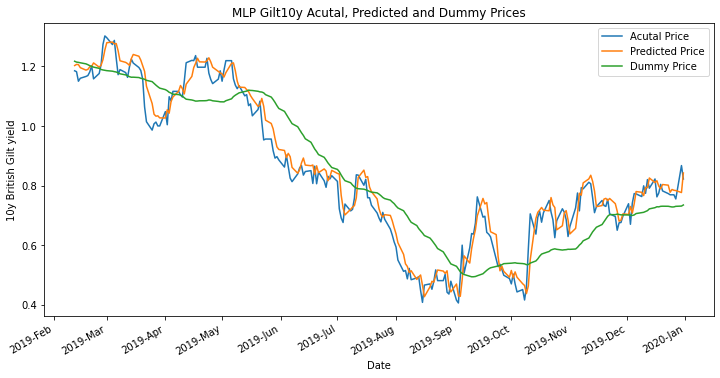

In [21]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

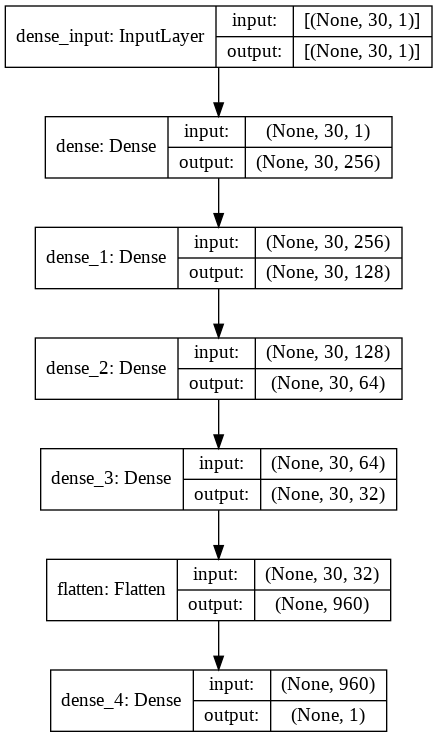

In [22]:
plot_model(model, show_shapes=True, expand_nested=True)

In [23]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.0022505288068775985
RMSE:  0.04743973868896833
MAE:  0.03677064185903337
Dummy MSE:  0.013891737694778073
Dummy RMSE:  0.11786321603782103
Dummy MAE:  0.09977998323101281


In [24]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/MLP_Gilt10y/assets
